# Welcome to 24-789 Homework 3

In this homework you will implement a [Denoising Diffusion Probabilistic Model](https://arxiv.org/pdf/2006.11239.pdf). Please start early as diffusion models are notoriously slow to train. Please remember to restart and run all before submission.

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms 
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from unet import Unet
import os
import math
from matplotlib import pyplot as plt

torch.manual_seed(0)

In [2]:
def create_mnist_dataloaders(batch_size,image_size=28,num_workers=2):
    '''
        Data loading code. Do not modify.
    '''
    
    preprocess=transforms.Compose([transforms.Resize(image_size),\
                                    transforms.ToTensor(),\
                                    transforms.Normalize([0.5],[0.5])]) #[0,1] to [-1,1]

    train_dataset=MNIST(root="./mnist_data",\
                        train=True,\
                        download=True,\
                        transform=preprocess
                        )
    
    # Pick out only the first 5000 1s
    valid_idxs = []
    for idx, d in enumerate(train_dataset):
        if(d[1] in [1]):
            valid_idxs.append(idx)
        if(len(valid_idxs) >= 5000):
            break

    # Create subset
    train_dataset = torch.utils.data.Subset(train_dataset, valid_idxs)

    return DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)

## a,b,c,d) Model Implementation

In this section you will implement each part of the diffusion model. That is the model parameters, forward diffusion, reverse diffusion, and the denoising sampling procedure.

In [3]:
import torch.nn as nn
import torch
import math
from unet import Unet
from tqdm import tqdm

class MNISTDiffusion(nn.Module):
    def __init__(self,image_size,in_channels,time_embedding_dim=256,timesteps=1000,base_dim=32,dim_mults= [1, 2, 4, 8]):
        super().__init__()
        
        ###
        #  Part a: Your code here
        ###
        self.timesteps=timesteps
        self.in_channels=in_channels
        self.image_size=image_size

        betas=self._cosine_variance_schedule(timesteps)

        alphas=1.-betas
        alphas_cumprod=torch.cumprod(alphas,dim=-1)

        self.register_buffer("betas",betas)
        self.register_buffer("alphas",alphas)
        self.register_buffer("alphas_cumprod",alphas_cumprod)
        self.register_buffer("sqrt_alphas_cumprod",torch.sqrt(alphas_cumprod))
        self.register_buffer("sqrt_one_minus_alphas_cumprod",torch.sqrt(1.-alphas_cumprod))

        self.model=Unet(timesteps,time_embedding_dim,in_channels,in_channels,base_dim,dim_mults)

    def forward(self,x,noise):
        # x:NCHW
        # Generate a target time, run forward diffusion, and predict
        
        ###
        #  Part b: Your code here
        ###
        t=torch.randint(0,self.timesteps,(x.shape[0],)).to(x.device)
        x_t=self._forward_diffusion(x,t,noise)
        pred_noise=self.model(x_t,t)

        return pred_noise

    @torch.no_grad()
    def sampling(self,n_samples,device="cuda"):
        
        ###
        #  Part d: Your code here
        ###
        x_t=torch.randn((n_samples,self.in_channels,self.image_size,self.image_size)).to(device)
        all_xt = torch.empty(self.timesteps, 36, 1, 28, 28)
        all_xt[0] = x_t
        for i in tqdm(range(self.timesteps-1,-1,-1),desc="Sampling"):
            #print(i)
            noise=torch.randn_like(x_t).to(device)
            t=torch.tensor([i for _ in range(n_samples)]).to(device)

            x_t=self._reverse_diffusion(x_t.clone(),t,noise)

            all_xt[i] = x_t.clone()
            
        x_t=(x_t+1.)/2.
        all_xt = (all_xt + 1.)/2.

        return x_t.clone(), all_xt.clone()
    
    def _cosine_variance_schedule(self,timesteps,epsilon= 0.008):
        steps=torch.linspace(0,timesteps,steps=timesteps+1,dtype=torch.float32)
        f_t=torch.cos(((steps/timesteps+epsilon)/(1.0+epsilon))*math.pi*0.5)**2
        betas=torch.clip(1.0-f_t[1:]/f_t[:timesteps],0.0,0.999)

        return betas

    def _forward_diffusion(self,x_0,t,noise):
        
        ###
        #  Part b: Your code here
        ###
        
        assert x_0.shape==noise.shape
        return self.sqrt_alphas_cumprod.gather(-1,t).reshape(x_0.shape[0],1,1,1)*x_0+ \
                self.sqrt_one_minus_alphas_cumprod.gather(-1,t).reshape(x_0.shape[0],1,1,1)*noise


    @torch.no_grad()
    def _reverse_diffusion(self,x_t,t,noise):
        '''
        p(x_{t-1}|x_{t})-> mean,std

        pred_noise-> pred_mean and pred_std
        '''
        
        ###
        #  Part c: Your code here
        ###
        pred=self.model(x_t,t)

        alpha_t=self.alphas.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        alpha_t_cumprod=self.alphas_cumprod.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        beta_t=self.betas.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        sqrt_one_minus_alpha_cumprod_t=self.sqrt_one_minus_alphas_cumprod.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        mean=(1./torch.sqrt(alpha_t))*(x_t-((1.0-alpha_t)/sqrt_one_minus_alpha_cumprod_t)*pred)

        if t.min()>0:
            alpha_t_cumprod_prev=self.alphas_cumprod.gather(-1,t-1).reshape(x_t.shape[0],1,1,1)
            std=torch.sqrt(beta_t*(1.-alpha_t_cumprod_prev)/(1.-alpha_t_cumprod))
        else:
            std=0.0

        return mean+std*noise   


## e) Model Training

Now it is time to implement your training loop. You will need to choose a learning rate, batch size, number of epochs, model dimension, and number of timesteps. You will also need to select an optimizer, scheduler, and loss function.

In [4]:
def main():
    device = "cuda" if torch.cuda.is_available() else 'cpu'

    # Model and training hyperparameters
    lr = 1e-3
    batch_size = 64
    epochs = 100
    model_base_dim = 64

    # Number of noising/denoising steps to take
    timesteps = 2000

    # Controls how often loss is printed and plots are generated
    log_freq = 10
    plot_freq = 10

    # For plotting. Do not modify.
    n_samples = 36

    train_dataloader=create_mnist_dataloaders(batch_size=batch_size,image_size=28)
    model=MNISTDiffusion(timesteps=timesteps,
                image_size=28,
                in_channels=1,
                base_dim=model_base_dim,
                dim_mults=[2,4]).to(device)


    optimizer=AdamW(model.parameters(),lr=lr)
    scheduler=OneCycleLR(optimizer,lr,total_steps=epochs*len(train_dataloader),pct_start=0.25,anneal_strategy='cos')
    loss_fn=nn.MSELoss(reduction='mean')

    global_steps=0
    for i in range(epochs):
        model.train()
        for j,(image,target) in enumerate(train_dataloader):
            
            # Implement your forward pass and backpropagation
            noise=torch.randn_like(image).to(device)
            image=image.to(device)
            pred=model(image,noise)
            loss=loss_fn(pred,noise)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
                
            # Print training progress
            global_steps+=1
            if j%log_freq==0:
                print("Epoch[{}/{}],Step[{}/{}],loss:{:.5f},lr:{:.5f}".format(i+1,epochs,j,len(train_dataloader),
                                                                    loss.detach().cpu().item(),scheduler.get_last_lr()[0]))
        if(i%plot_freq == 0):
            ckpt={"model":model.state_dict()}
            os.makedirs("results",exist_ok=True)
            torch.save(ckpt,"results/steps_{:0>8}.pt".format(global_steps))
            model.eval()
            s, samples = model.sampling(n_samples,device=device)
            save_image(s,"results/steps_{:0>8}.png".format(global_steps),nrow=int(math.sqrt(n_samples)))

    # Final round of plots
    os.makedirs("results",exist_ok=True)
    torch.save(ckpt,"results/steps_{:0>8}.pt".format(global_steps))

    model.eval()
    s, samples=model.sampling(n_samples,device=device)
    save_image(s,"results/steps_{:0>8}.png".format(global_steps),nrow=int(math.sqrt(n_samples)))

    return samples

In [5]:
samples = main()

Epoch[1/100],Step[0/79],loss:1.15744,lr:0.00004
Epoch[1/100],Step[10/79],loss:1.13477,lr:0.00004
Epoch[1/100],Step[20/79],loss:1.09272,lr:0.00004
Epoch[1/100],Step[30/79],loss:1.08360,lr:0.00004
Epoch[1/100],Step[40/79],loss:1.05069,lr:0.00004
Epoch[1/100],Step[50/79],loss:1.04464,lr:0.00004
Epoch[1/100],Step[60/79],loss:1.02831,lr:0.00004
Epoch[1/100],Step[70/79],loss:1.02331,lr:0.00004


Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:45<00:00, 43.70it/s]


Epoch[2/100],Step[0/79],loss:0.98743,lr:0.00004
Epoch[2/100],Step[10/79],loss:0.97500,lr:0.00004
Epoch[2/100],Step[20/79],loss:0.95444,lr:0.00005
Epoch[2/100],Step[30/79],loss:0.94273,lr:0.00005
Epoch[2/100],Step[40/79],loss:0.93690,lr:0.00005
Epoch[2/100],Step[50/79],loss:0.89015,lr:0.00005
Epoch[2/100],Step[60/79],loss:0.89886,lr:0.00005
Epoch[2/100],Step[70/79],loss:0.86507,lr:0.00005
Epoch[3/100],Step[0/79],loss:0.83940,lr:0.00006
Epoch[3/100],Step[10/79],loss:0.80631,lr:0.00006
Epoch[3/100],Step[20/79],loss:0.78852,lr:0.00006
Epoch[3/100],Step[30/79],loss:0.77430,lr:0.00006
Epoch[3/100],Step[40/79],loss:0.75950,lr:0.00006
Epoch[3/100],Step[50/79],loss:0.72478,lr:0.00007
Epoch[3/100],Step[60/79],loss:0.71511,lr:0.00007
Epoch[3/100],Step[70/79],loss:0.69476,lr:0.00007
Epoch[4/100],Step[0/79],loss:0.67252,lr:0.00007
Epoch[4/100],Step[10/79],loss:0.62467,lr:0.00008
Epoch[4/100],Step[20/79],loss:0.64333,lr:0.00008
Epoch[4/100],Step[30/79],loss:0.59175,lr:0.00008
Epoch[4/100],Step[40/79

Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 45.89it/s]


Epoch[12/100],Step[0/79],loss:0.15758,lr:0.00043
Epoch[12/100],Step[10/79],loss:0.17988,lr:0.00044
Epoch[12/100],Step[20/79],loss:0.14903,lr:0.00045
Epoch[12/100],Step[30/79],loss:0.13337,lr:0.00045
Epoch[12/100],Step[40/79],loss:0.14320,lr:0.00046
Epoch[12/100],Step[50/79],loss:0.12710,lr:0.00047
Epoch[12/100],Step[60/79],loss:0.11562,lr:0.00048
Epoch[12/100],Step[70/79],loss:0.12442,lr:0.00048
Epoch[13/100],Step[0/79],loss:0.14037,lr:0.00049
Epoch[13/100],Step[10/79],loss:0.12359,lr:0.00050
Epoch[13/100],Step[20/79],loss:0.11758,lr:0.00051
Epoch[13/100],Step[30/79],loss:0.13536,lr:0.00051
Epoch[13/100],Step[40/79],loss:0.12141,lr:0.00052
Epoch[13/100],Step[50/79],loss:0.10330,lr:0.00053
Epoch[13/100],Step[60/79],loss:0.11507,lr:0.00054
Epoch[13/100],Step[70/79],loss:0.11789,lr:0.00054
Epoch[14/100],Step[0/79],loss:0.11159,lr:0.00055
Epoch[14/100],Step[10/79],loss:0.10988,lr:0.00056
Epoch[14/100],Step[20/79],loss:0.10463,lr:0.00057
Epoch[14/100],Step[30/79],loss:0.12085,lr:0.00057
Epo

Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 45.83it/s]


Epoch[22/100],Step[0/79],loss:0.05284,lr:0.00094
Epoch[22/100],Step[10/79],loss:0.05958,lr:0.00094
Epoch[22/100],Step[20/79],loss:0.05094,lr:0.00095
Epoch[22/100],Step[30/79],loss:0.04776,lr:0.00095
Epoch[22/100],Step[40/79],loss:0.06436,lr:0.00096
Epoch[22/100],Step[50/79],loss:0.04627,lr:0.00096
Epoch[22/100],Step[60/79],loss:0.05035,lr:0.00096
Epoch[22/100],Step[70/79],loss:0.06714,lr:0.00096
Epoch[23/100],Step[0/79],loss:0.04877,lr:0.00097
Epoch[23/100],Step[10/79],loss:0.07314,lr:0.00097
Epoch[23/100],Step[20/79],loss:0.05812,lr:0.00097
Epoch[23/100],Step[30/79],loss:0.05242,lr:0.00097
Epoch[23/100],Step[40/79],loss:0.05942,lr:0.00098
Epoch[23/100],Step[50/79],loss:0.05058,lr:0.00098
Epoch[23/100],Step[60/79],loss:0.05948,lr:0.00098
Epoch[23/100],Step[70/79],loss:0.04994,lr:0.00098
Epoch[24/100],Step[0/79],loss:0.05046,lr:0.00099
Epoch[24/100],Step[10/79],loss:0.04993,lr:0.00099
Epoch[24/100],Step[20/79],loss:0.05942,lr:0.00099
Epoch[24/100],Step[30/79],loss:0.05383,lr:0.00099
Epo

Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 45.53it/s]


Epoch[32/100],Step[0/79],loss:0.04324,lr:0.00098
Epoch[32/100],Step[10/79],loss:0.03621,lr:0.00098
Epoch[32/100],Step[20/79],loss:0.04747,lr:0.00098
Epoch[32/100],Step[30/79],loss:0.04654,lr:0.00098
Epoch[32/100],Step[40/79],loss:0.04859,lr:0.00098
Epoch[32/100],Step[50/79],loss:0.03678,lr:0.00098
Epoch[32/100],Step[60/79],loss:0.03663,lr:0.00098
Epoch[32/100],Step[70/79],loss:0.04176,lr:0.00098
Epoch[33/100],Step[0/79],loss:0.03954,lr:0.00098
Epoch[33/100],Step[10/79],loss:0.03938,lr:0.00098
Epoch[33/100],Step[20/79],loss:0.03232,lr:0.00098
Epoch[33/100],Step[30/79],loss:0.03315,lr:0.00098
Epoch[33/100],Step[40/79],loss:0.03973,lr:0.00098
Epoch[33/100],Step[50/79],loss:0.04475,lr:0.00097
Epoch[33/100],Step[60/79],loss:0.04229,lr:0.00097
Epoch[33/100],Step[70/79],loss:0.03891,lr:0.00097
Epoch[34/100],Step[0/79],loss:0.04680,lr:0.00097
Epoch[34/100],Step[10/79],loss:0.03785,lr:0.00097
Epoch[34/100],Step[20/79],loss:0.04134,lr:0.00097
Epoch[34/100],Step[30/79],loss:0.03521,lr:0.00097
Epo

Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:44<00:00, 44.95it/s]


Epoch[42/100],Step[0/79],loss:0.03431,lr:0.00089
Epoch[42/100],Step[10/79],loss:0.03766,lr:0.00089
Epoch[42/100],Step[20/79],loss:0.03133,lr:0.00089
Epoch[42/100],Step[30/79],loss:0.03133,lr:0.00089
Epoch[42/100],Step[40/79],loss:0.03313,lr:0.00088
Epoch[42/100],Step[50/79],loss:0.02675,lr:0.00088
Epoch[42/100],Step[60/79],loss:0.03010,lr:0.00088
Epoch[42/100],Step[70/79],loss:0.03045,lr:0.00088
Epoch[43/100],Step[0/79],loss:0.03032,lr:0.00088
Epoch[43/100],Step[10/79],loss:0.03552,lr:0.00088
Epoch[43/100],Step[20/79],loss:0.03759,lr:0.00087
Epoch[43/100],Step[30/79],loss:0.03524,lr:0.00087
Epoch[43/100],Step[40/79],loss:0.03296,lr:0.00087
Epoch[43/100],Step[50/79],loss:0.03514,lr:0.00087
Epoch[43/100],Step[60/79],loss:0.03091,lr:0.00087
Epoch[43/100],Step[70/79],loss:0.03117,lr:0.00087
Epoch[44/100],Step[0/79],loss:0.02937,lr:0.00086
Epoch[44/100],Step[10/79],loss:0.04007,lr:0.00086
Epoch[44/100],Step[20/79],loss:0.03195,lr:0.00086
Epoch[44/100],Step[30/79],loss:0.03742,lr:0.00086
Epo

Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 45.83it/s]


Epoch[52/100],Step[0/79],loss:0.02479,lr:0.00073
Epoch[52/100],Step[10/79],loss:0.02832,lr:0.00073
Epoch[52/100],Step[20/79],loss:0.04053,lr:0.00073
Epoch[52/100],Step[30/79],loss:0.04736,lr:0.00072
Epoch[52/100],Step[40/79],loss:0.03398,lr:0.00072
Epoch[52/100],Step[50/79],loss:0.03215,lr:0.00072
Epoch[52/100],Step[60/79],loss:0.02557,lr:0.00072
Epoch[52/100],Step[70/79],loss:0.03602,lr:0.00071
Epoch[53/100],Step[0/79],loss:0.03287,lr:0.00071
Epoch[53/100],Step[10/79],loss:0.03279,lr:0.00071
Epoch[53/100],Step[20/79],loss:0.03017,lr:0.00071
Epoch[53/100],Step[30/79],loss:0.03927,lr:0.00071
Epoch[53/100],Step[40/79],loss:0.03497,lr:0.00070
Epoch[53/100],Step[50/79],loss:0.03187,lr:0.00070
Epoch[53/100],Step[60/79],loss:0.02535,lr:0.00070
Epoch[53/100],Step[70/79],loss:0.02531,lr:0.00070
Epoch[54/100],Step[0/79],loss:0.03800,lr:0.00069
Epoch[54/100],Step[10/79],loss:0.03100,lr:0.00069
Epoch[54/100],Step[20/79],loss:0.02525,lr:0.00069
Epoch[54/100],Step[30/79],loss:0.03359,lr:0.00069
Epo

Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:44<00:00, 44.51it/s]


Epoch[62/100],Step[0/79],loss:0.03364,lr:0.00053
Epoch[62/100],Step[10/79],loss:0.03028,lr:0.00053
Epoch[62/100],Step[20/79],loss:0.02744,lr:0.00053
Epoch[62/100],Step[30/79],loss:0.03007,lr:0.00052
Epoch[62/100],Step[40/79],loss:0.02869,lr:0.00052
Epoch[62/100],Step[50/79],loss:0.02625,lr:0.00052
Epoch[62/100],Step[60/79],loss:0.02908,lr:0.00051
Epoch[62/100],Step[70/79],loss:0.03056,lr:0.00051
Epoch[63/100],Step[0/79],loss:0.03071,lr:0.00051
Epoch[63/100],Step[10/79],loss:0.02780,lr:0.00051
Epoch[63/100],Step[20/79],loss:0.02113,lr:0.00050
Epoch[63/100],Step[30/79],loss:0.02462,lr:0.00050
Epoch[63/100],Step[40/79],loss:0.02523,lr:0.00050
Epoch[63/100],Step[50/79],loss:0.02377,lr:0.00050
Epoch[63/100],Step[60/79],loss:0.02374,lr:0.00049
Epoch[63/100],Step[70/79],loss:0.02955,lr:0.00049
Epoch[64/100],Step[0/79],loss:0.02879,lr:0.00049
Epoch[64/100],Step[10/79],loss:0.02224,lr:0.00049
Epoch[64/100],Step[20/79],loss:0.03494,lr:0.00048
Epoch[64/100],Step[30/79],loss:0.02553,lr:0.00048
Epo

Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 45.61it/s]


Epoch[72/100],Step[0/79],loss:0.02424,lr:0.00033
Epoch[72/100],Step[10/79],loss:0.02534,lr:0.00032
Epoch[72/100],Step[20/79],loss:0.02814,lr:0.00032
Epoch[72/100],Step[30/79],loss:0.02447,lr:0.00032
Epoch[72/100],Step[40/79],loss:0.02408,lr:0.00032
Epoch[72/100],Step[50/79],loss:0.02153,lr:0.00031
Epoch[72/100],Step[60/79],loss:0.02342,lr:0.00031
Epoch[72/100],Step[70/79],loss:0.02606,lr:0.00031
Epoch[73/100],Step[0/79],loss:0.02566,lr:0.00031
Epoch[73/100],Step[10/79],loss:0.02423,lr:0.00030
Epoch[73/100],Step[20/79],loss:0.02769,lr:0.00030
Epoch[73/100],Step[30/79],loss:0.02808,lr:0.00030
Epoch[73/100],Step[40/79],loss:0.02362,lr:0.00030
Epoch[73/100],Step[50/79],loss:0.03227,lr:0.00029
Epoch[73/100],Step[60/79],loss:0.03170,lr:0.00029
Epoch[73/100],Step[70/79],loss:0.03509,lr:0.00029
Epoch[74/100],Step[0/79],loss:0.02772,lr:0.00029
Epoch[74/100],Step[10/79],loss:0.02897,lr:0.00028
Epoch[74/100],Step[20/79],loss:0.03134,lr:0.00028
Epoch[74/100],Step[30/79],loss:0.02366,lr:0.00028
Epo

Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 45.92it/s]


Epoch[82/100],Step[0/79],loss:0.02215,lr:0.00015
Epoch[82/100],Step[10/79],loss:0.02739,lr:0.00015
Epoch[82/100],Step[20/79],loss:0.02631,lr:0.00015
Epoch[82/100],Step[30/79],loss:0.02425,lr:0.00014
Epoch[82/100],Step[40/79],loss:0.02394,lr:0.00014
Epoch[82/100],Step[50/79],loss:0.02177,lr:0.00014
Epoch[82/100],Step[60/79],loss:0.02693,lr:0.00014
Epoch[82/100],Step[70/79],loss:0.02683,lr:0.00014
Epoch[83/100],Step[0/79],loss:0.02522,lr:0.00014
Epoch[83/100],Step[10/79],loss:0.02449,lr:0.00013
Epoch[83/100],Step[20/79],loss:0.02253,lr:0.00013
Epoch[83/100],Step[30/79],loss:0.02875,lr:0.00013
Epoch[83/100],Step[40/79],loss:0.02231,lr:0.00013
Epoch[83/100],Step[50/79],loss:0.02338,lr:0.00013
Epoch[83/100],Step[60/79],loss:0.02658,lr:0.00012
Epoch[83/100],Step[70/79],loss:0.02379,lr:0.00012
Epoch[84/100],Step[0/79],loss:0.02844,lr:0.00012
Epoch[84/100],Step[10/79],loss:0.02132,lr:0.00012
Epoch[84/100],Step[20/79],loss:0.02733,lr:0.00012
Epoch[84/100],Step[30/79],loss:0.02152,lr:0.00012
Epo

Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 45.97it/s]


Epoch[92/100],Step[0/79],loss:0.02731,lr:0.00003
Epoch[92/100],Step[10/79],loss:0.02859,lr:0.00003
Epoch[92/100],Step[20/79],loss:0.02527,lr:0.00003
Epoch[92/100],Step[30/79],loss:0.02475,lr:0.00003
Epoch[92/100],Step[40/79],loss:0.02407,lr:0.00003
Epoch[92/100],Step[50/79],loss:0.02506,lr:0.00003
Epoch[92/100],Step[60/79],loss:0.02443,lr:0.00003
Epoch[92/100],Step[70/79],loss:0.02238,lr:0.00003
Epoch[93/100],Step[0/79],loss:0.02335,lr:0.00003
Epoch[93/100],Step[10/79],loss:0.02516,lr:0.00003
Epoch[93/100],Step[20/79],loss:0.02431,lr:0.00003
Epoch[93/100],Step[30/79],loss:0.02369,lr:0.00003
Epoch[93/100],Step[40/79],loss:0.02382,lr:0.00002
Epoch[93/100],Step[50/79],loss:0.02313,lr:0.00002
Epoch[93/100],Step[60/79],loss:0.02759,lr:0.00002
Epoch[93/100],Step[70/79],loss:0.02523,lr:0.00002
Epoch[94/100],Step[0/79],loss:0.02518,lr:0.00002
Epoch[94/100],Step[10/79],loss:0.02531,lr:0.00002
Epoch[94/100],Step[20/79],loss:0.02491,lr:0.00002
Epoch[94/100],Step[30/79],loss:0.02210,lr:0.00002
Epo

Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:45<00:00, 43.88it/s]


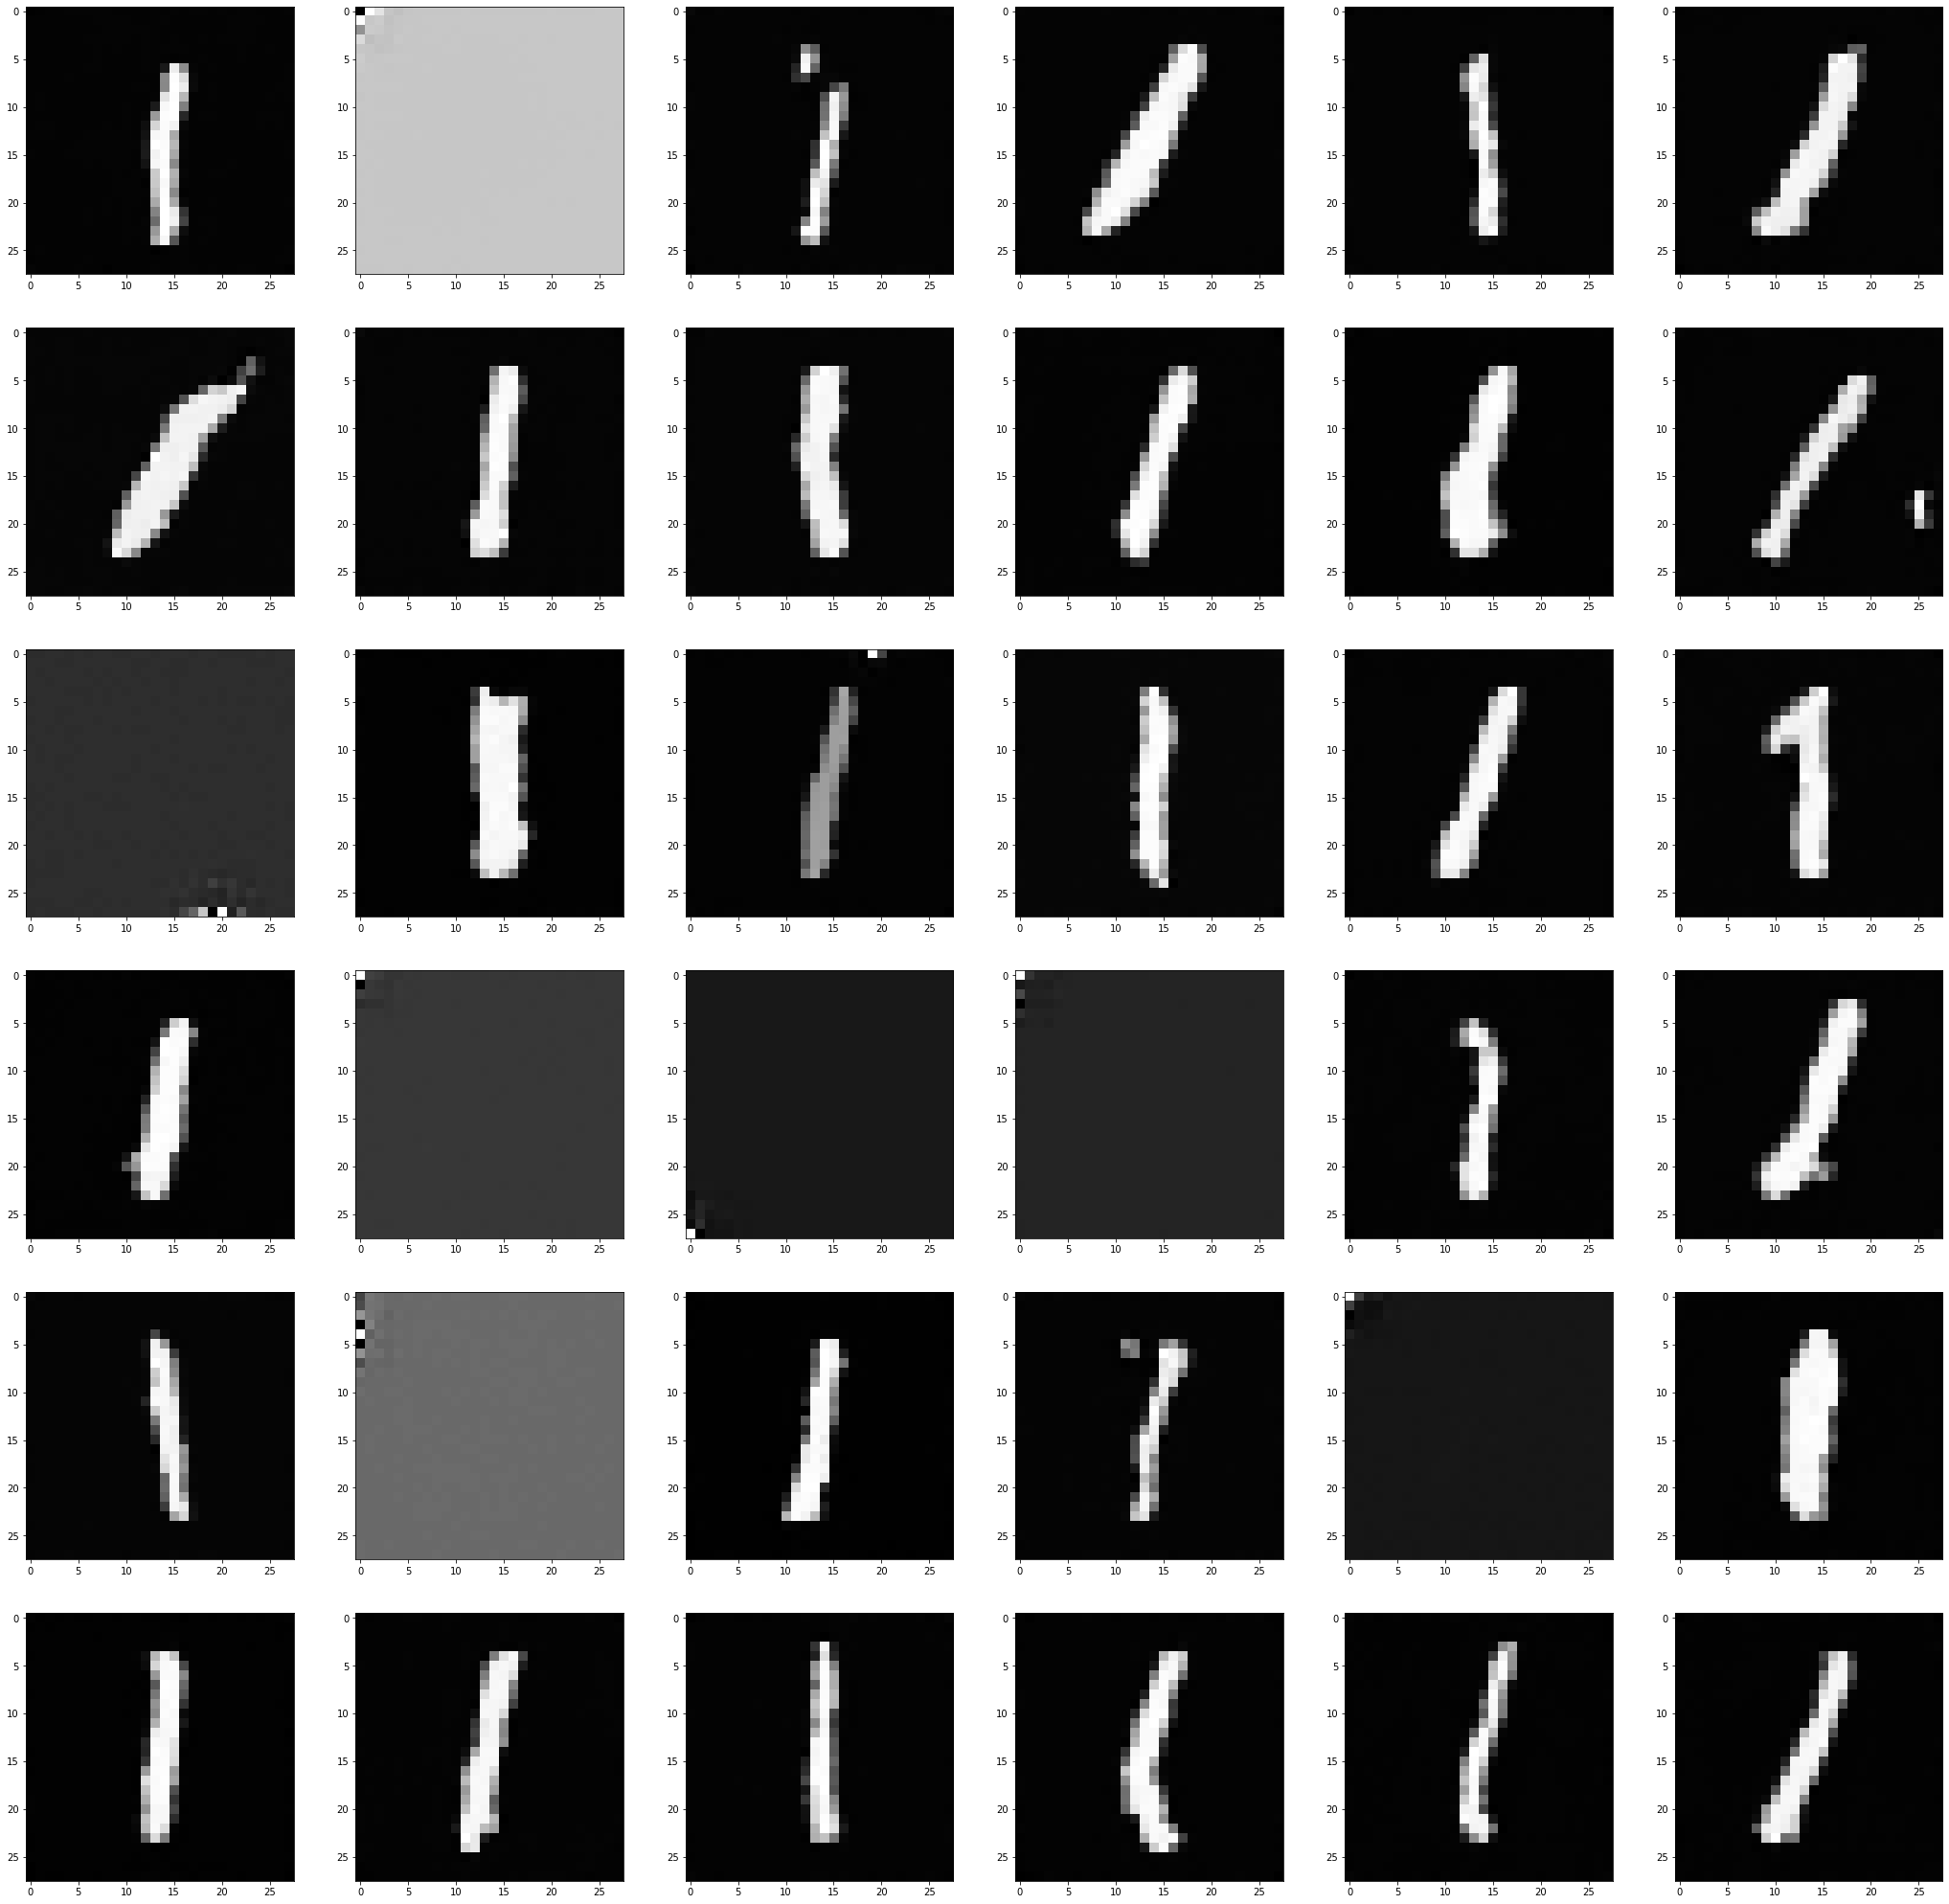

In [6]:
# Plotting code for your final samples
fig, ax = plt.subplots(ncols=6, nrows=6, figsize=(36,36))
for i in range(36):
    ax[i//6][i%6].imshow(samples[0][i][0], cmap='gray',  interpolation='nearest')
plt.savefig("./learned_diffusion_ones.pdf")
plt.show()

## f) Diffusion Visualization
Here you will need to implement a plotting function that visualizes noise turning into a clean sample. Do not forget to label each image with its corresponding denoising step.

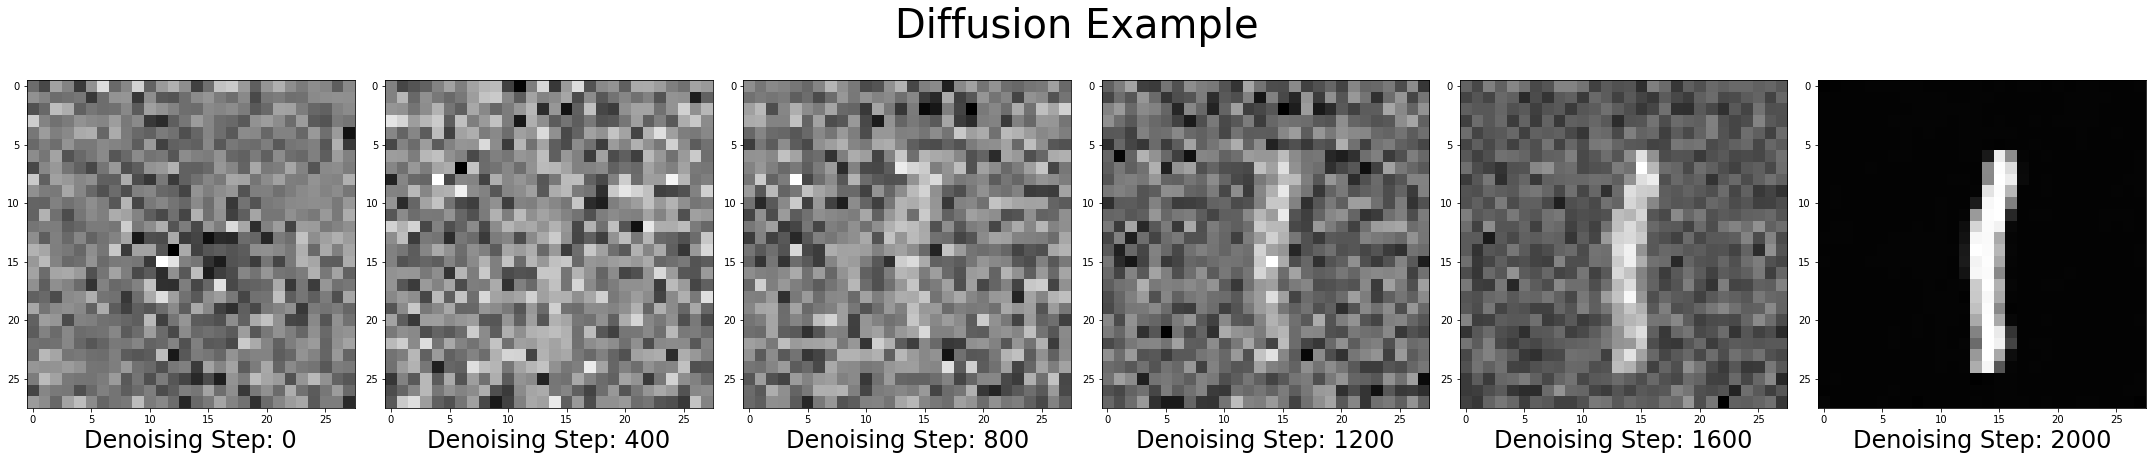

In [7]:
fig, ax = plt.subplots(ncols=6, figsize=(30,7))

###
#  Your code here
###
for idx, i in enumerate(range(samples.shape[0], 0, -samples.shape[0]//5)):
    ax[idx].imshow(samples[i-1][0][0], cmap='gray')
    ax[idx].set_xlabel("Denoising Step: {}".format(2000-i), fontsize=24)
ax[-1].imshow(samples[0][0][0], cmap='gray')
ax[-1].set_xlabel("Denoising Step: {}".format(2000), fontsize=24)
fig.suptitle("Diffusion Example", fontsize=40, y=0.92)
plt.tight_layout()
plt.savefig("./diffusion_example.pdf")
plt.show()